# Spectral Analysis using xrft and Pangeo
**Dhruv Balwada, Takaya Uchida, and Ryan Abernathey**  
*University of Washington,  
Institut des Géosciences de l'Environnement, and  
Columbia University*  
Contact: dbalwada@uw.edu

**Abstract**
 >Turbulent flows, such as the macroscale chaotic flows of the ocean and atmosphere, are inherently multiscale phenomena. With the advancements in computational power and modern satellite observational platforms, we are able to generate model and observational fields that are able to sample the evolution of these turbulent flows. Spectral analysis of these turbulent flows is an extremely powerful tool that allows us to glean a deeper fundamental understanding of how the turbulence transfers and equilibrates energy and tracers across scales, or simply put helps us understand how do flow structures grow and decay?  
Turbulence resolving data sets are generally large in size due to high spatial and temporal resolution requirements to sample the rapidly evolving turbulent flows. This poses a unique challenge for the computation of the spectral properties of these fields. In this notebook we leverage a python toolbox - xrft (https://xrft.readthedocs.io/), which is part of the Pangeo (https://pangeo.io/) stack, along with the resources of Pangeo cloud to demonstrate how spectral calculations can be carried out efficiently. Xrft leverages the existing architecture of xarray, which allows the tracking of its metadata (i.e. spatial and temporal coordinates), and dask, which allows automatic parallelization, to easily and rapidly calculate discrete fourier transforms, while tracking the metadata of the variables. In particular, we show how to use xrft to estimate the power spectra, cross-spectra and spectral transfer rates of variables in a submesoscale resolving ocean simulation. However, the tools and workflows are general and can easily be extended to other simulation outputs and satellite based surface fields.

**Contents**
* Load data from LLC4320
* Fields
* Power Spectra
* Cross Spectra
* Spectral transfer rates

In [14]:
# Setup cluster
from dask.distributed import Client, progress
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=10)
cluster

distributed.scheduler - INFO - Clear task state
/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
distributed.scheduler - INFO -   Scheduler at:   tcp://10.32.16.29:43937
distributed.scheduler - INFO -   dashboard at:                    :38675


In [15]:
client = Client(cluster)
client

distributed.scheduler - INFO - Receive client connection: Client-f44fc9d4-9093-11ea-840a-02629f7bdac6
distributed.core - INFO - Starting established connection


<Client: 'tcp://10.32.16.29:43937' processes=0 threads=0, memory=0 B>

distributed.scheduler - INFO - Register tcp://10.32.53.5:42729
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.53.5:42729
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.48.5:36897
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.48.5:36897
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.36.5:37323
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.36.5:37323
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.15.7:37063
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.15.7:37063
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.87.5:42987
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.87.5:42987
distributed.core - INFO

In [16]:
# Load some useful modules 
import numpy as np
import xarray as xr
import xrft
import intake
from xmitgcm import llcreader
from matplotlib import pyplot as plt

%matplotlib inline

In [17]:
cat_url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml"
cat = intake.Catalog(cat_url)

In [18]:
# Get variables from catalog
sst = cat.LLC4320_SST.to_dask()
sss = cat.LLC4320_SSS.to_dask()
ssh = cat.LLC4320_SSH.to_dask()
u = cat.LLC4320_SSU.to_dask()
v = cat.LLC4320_SSV.to_dask()

In [19]:
sst

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, j: 4320, time: 9030)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
Data variables:
    SST      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...
    source:       MITgcm
    title:        netCDF wrapper of MITgcm MDS binary data

In [20]:
ds = xr.merge([ssh, sst, sss, u, v])
ds = llcreader.llcmodel.faces_dataset_to_latlon(ds, metric_vector_pairs=[])
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 17280, i_g: 17280, j: 12960, j_g: 12960, k: 90, k_l: 90, k_p1: 91, k_u: 90, time: 9030)
Coordinates:
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89 90
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
Data variables:
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SST      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SSS      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(9030,), meta=np.ndarray>
    U        (time, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    V        (time, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

In [21]:
coords = cat.LLC4320_grid.to_dask().reset_coords()
coords = llcreader.llcmodel.faces_dataset_to_latlon(coords)
coords

<xarray.Dataset>
Dimensions:  (face: 13, i: 17280, i_g: 17280, j: 12960, j_g: 12960, k_p1: 2, time: 9030)
Coordinates:
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * k_p1     (k_p1) int64 0 1
Data variables:
    CS       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    PHrefC   float32 15.4017
    PHrefF   (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    XG       (j_g, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    YG       (j_g, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    Z        float32 -1.57
    Zl       float32 -1.0
    Zp1      (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    Zu       float32 -2.14
    drC      (k_p1) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    drF      float32 1.14
    hFacC    (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    hFacS    (j_g, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    hFacW    (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(9030,), meta=np.ndarray>
    k        int64 1
    k_l      int64 1
    k_u      int64 1
    rA       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    rAs      (j_g, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    rAw      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    rAz      (j_g, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dxC      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dyC      (j_g, i) float32 dask.array<chunksize=(1, 4320), meta=np.ndarray>
    dyG      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dxG      (j_g, i) float32 dask.array<chunksize=(1, 4320), meta=np.ndarray>

### Understand grids

In [35]:
YCcoarse = coords.YC.coarsen(i=20, j=20).mean()
XCcoarse = coords.XC.coarsen(i=20, j=20).mean()
RAcoarse = coords.rA.coarsen(i=20, j=20).mean()

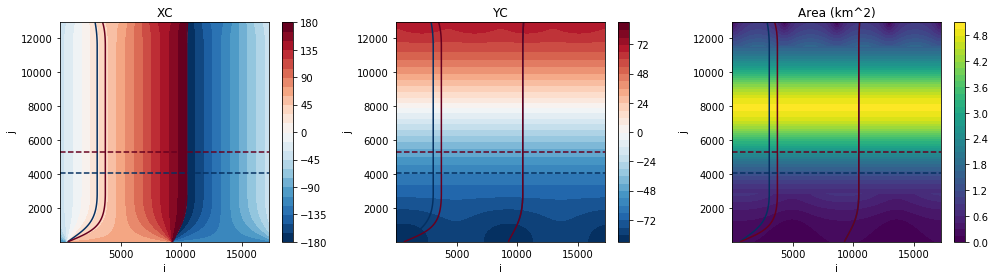

distributed.scheduler - INFO - Register tcp://10.32.22.2:39499
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.22.2:39499
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.22.3:34325
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.22.3:34325
distributed.core - INFO - Starting established connection


In [48]:
plt.figure(figsize=(14,4))

plt.subplot(131)
XCcoarse.plot.contourf(levels=36)
XCcoarse.plot.contour(levels=[26, 40])
YCcoarse.plot.contour(levels=[-60, -45])

plt.title('XC')

plt.subplot(132)
YCcoarse.plot.contourf(levels=36)
XCcoarse.plot.contour(levels=[26, 40])
YCcoarse.plot.contour(levels=[-60, -45])

plt.title('YC')

plt.subplot(133)
(RAcoarse/1e6).plot.contourf(levels=35)
XCcoarse.plot.contour(levels=[26, 40])
YCcoarse.plot.contour(levels=[-60, -45])

plt.title('Area (km^2)')

plt.tight_layout()

### Select Area

SOGOS area   
Lat ~ -55 -> -48  
Lon ~ 28 -> 40

In [60]:
sel_sogos = np.logical_and(np.logical_and(coords.XC>28, coords.XC<40 ), np.logical_and(coords.YC>-56, coords.YC<-48 ))

In [63]:
X = coords.XC.where(sel_sogos, drop=True)
Y = coords.YC.where(sel_sogos, drop=True)

In [83]:
Xmean = X.mean(['j'])
Ymean = Y.mean(['i'])
Xmax = X.max(['j'])
Xmin = X.min(['j'])
Ymax = Y.max(['i'])
Ymin = Y.min(['i'])

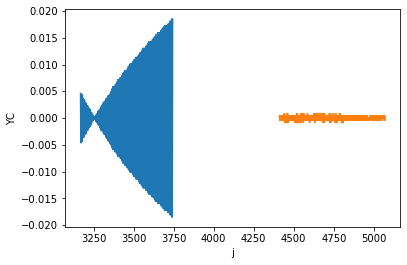

In [89]:
#Xmean.plot()
((Xmean-Xmin)*110).plot()
((Ymean-Ymin)*110).plot()

In [64]:
SST = ds.SST.where(sel_sogos, drop=True)

In [115]:
SSS = ds.SSS.where(sel_sogos, drop=True)

In [97]:
SSH = ds.Eta.where(sel_sogos, drop=True)

In [93]:
print(SST.time.isel(time=0).values)

2011-09-13T00:00:00.000000000


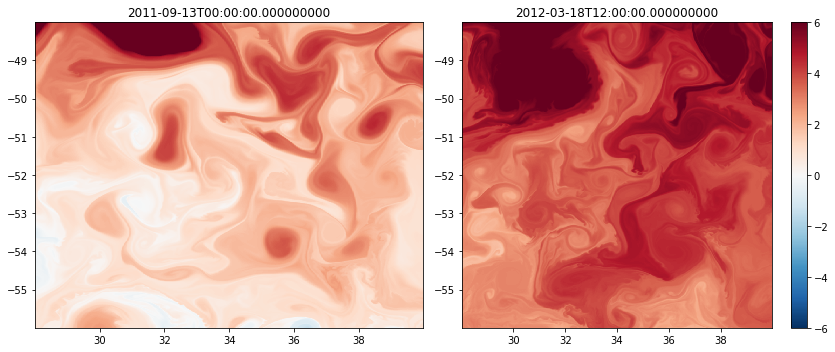

In [95]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.pcolormesh(Xmean, Ymean, SST.isel(time=0), vmin=-6, vmax=6, cmap='RdBu_r')
plt.title(SST.time.isel(time=0).values)

plt.subplot(122)
plt.pcolormesh(Xmean, Ymean, SST.isel(time=4500), vmin=-6, vmax=6, cmap='RdBu_r')
plt.title(SST.time.isel(time=4500).values)
plt.colorbar()

plt.tight_layout()

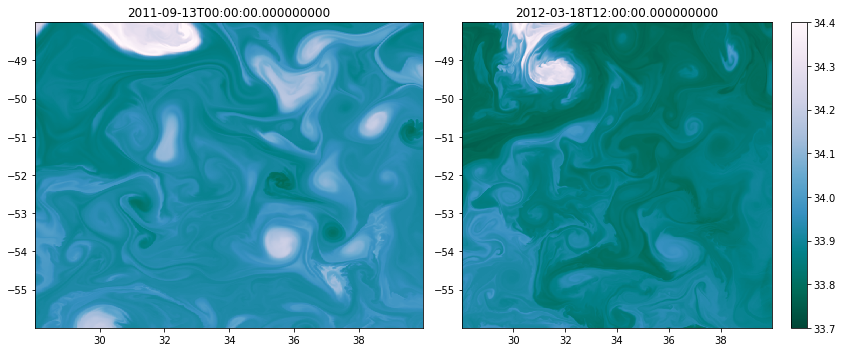

In [120]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.pcolormesh(Xmean, Ymean, SSS.isel(time=0), vmin=33.7, vmax=34.4, cmap='PuBuGn_r')
plt.title(SSS.time.isel(time=0).values)

plt.subplot(122)
plt.pcolormesh(Xmean, Ymean, SSS.isel(time=4500), vmin=33.7, vmax=34.4, cmap='PuBuGn_r')
plt.title(SSS.time.isel(time=4500).values)
plt.colorbar()

plt.tight_layout()

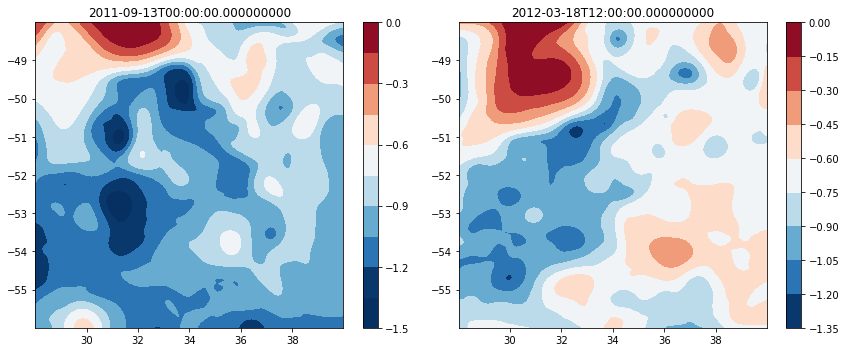

distributed.utils_perf - INFO - full garbage collection released 76.07 MB from 22185 reference cycles (threshold: 10.00 MB)


In [114]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.contourf(Xmean, Ymean, SSH.isel(time=slice(0,24)).resample(time='D').mean('time').isel(time=0), levels=11, vmin=-1.3, vmax=0, cmap='RdBu_r')
plt.colorbar()
plt.title(SST.time.isel(time=0).values)

plt.subplot(122)
plt.contourf(Xmean, Ymean,  SSH.isel(time=slice(4500,4524)).resample(time='D').mean('time').isel(time=0), levels=11, vmin=-1.3, vmax=0, cmap='RdBu_r')
plt.colorbar()
plt.title(SST.time.isel(time=4500).values)

plt.tight_layout()

distributed.core - INFO - Event loop was unresponsive in Scheduler for 7.19s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Scheduler for 7.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Scheduler for 10.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


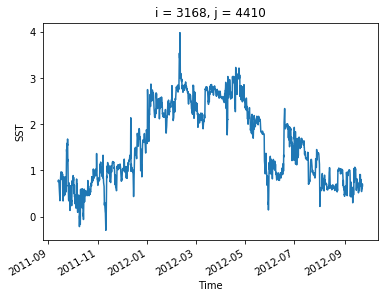

In [70]:
SST.isel(i=0, j=0).plot()

distributed.utils_perf - INFO - full garbage collection released 212.61 MB from 49249 reference cycles (threshold: 10.00 MB)


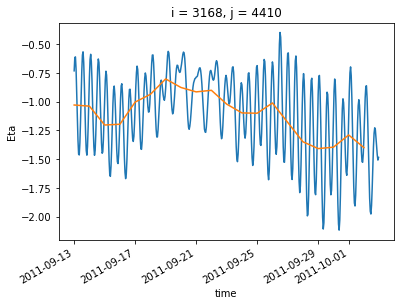

In [108]:
SSH.isel(i=0, j=0, time=slice(0,480)).plot()
SSH.isel(i=0, j=0, time=slice(0,480)).resample(time='D').mean().plot()